In [1]:
from ipywidgets import interact
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
tfb = tfp.bijectors
tfd = tfp.distributions

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

# Inferring a transition point in a timeseries
This notebook is inspired by an example from Ch1 of [probabilistic programming for hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers/blob/master/Chapter1_Introduction/Ch1_Introduction_TFP.ipynb)

We generate a sequence of integers representing some count (for example, number of text messages sent per day). The count is modeled as a Poisson distribution. The rate (mean) of the distribution jumps from one value to another at a specific point in time `tswitch = 25`. We will use TensorFlow probability to learn the two rate's and the switch time.

In [2]:
TSTART, TEND = 0, 100
RATE1, RATE2, TSWITCH = 20., 30., 25
t = np.arange(TSTART, TEND)

In [3]:
def generate(rate1, rate2, tswitch):
    rate = tf.gather([rate1, rate2], tf.to_int32(t > tswitch))
    return tfd.Poisson(rate=rate)

In [4]:
with tf.Session() as sess:
    y = sess.run(generate(RATE1, RATE2, TSWITCH).sample(5))

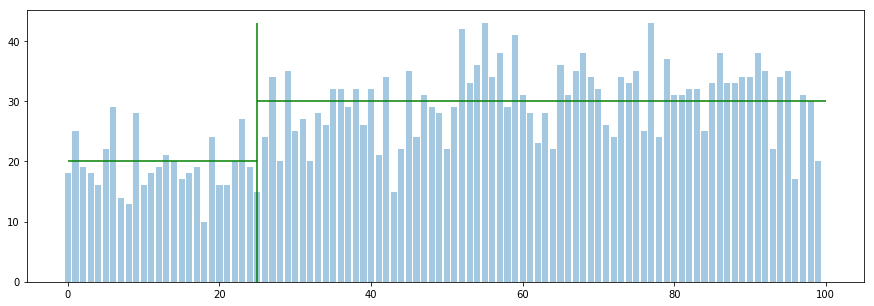

In [5]:
plt.figure(figsize=(15, 5))
plt.bar(t, y[0], alpha=.4)
plt.vlines(TSWITCH, ymin=0, ymax=max(y[0]), color='green')
plt.hlines(RATE1, xmin=TSTART, xmax=TSWITCH, color='green')
plt.hlines(RATE2, xmin=TSWITCH, xmax=TEND, color='green')
plt.show()

We will sample the distribution and learn the two rates and the switch time. We will make the following assumptions (priors):
- tswitch is uniformly distributed between 0 and 100
- rate1 and rate2 are exponentially distributed with rate equal to the mean value of y

In [6]:
RATE_INIT = y.mean()
TSWITCH_INIT = (TEND - TSTART) / 2.

def log_prob_prior(rate1, rate2, tswitch):
    rv_rate1 = tfd.Exponential(rate=RATE_INIT)
    rv_rate2 = tfd.Exponential(rate=RATE_INIT)    
    rv_tswitch = tfd.Uniform(low=TSTART, high=TEND)
    return (
        rv_rate1.log_prob(rate1) + 
        rv_rate2.log_prob(rate2) + 
        rv_tswitch.log_prob(tswitch)
    )
    
def log_prob_data(rate1, rate2, tswitch):
    rv_y = generate(rate1, rate2, tswitch)
    return tf.reduce_sum(rv_y.log_prob(y))

def log_prob(*args):
    return log_prob_prior(*args) + log_prob_data(*args)

Now we run MCMC to sample the posterior distribution. `log_prob_prior` can be thought of as a regularizer while `log_prob_data` is our training signal based on observations.

In [7]:
with tf.variable_scope(tf.get_variable_scope(), reuse=tf.AUTO_REUSE):
    step_size = tf.get_variable(
        name='step_size',
        initializer=tf.constant(.5),
        trainable=False,
        use_resource=True
    )

kernel = tfp.mcmc.HamiltonianMonteCarlo(
    target_log_prob_fn=log_prob,
    num_leapfrog_steps=2,
    step_size=step_size,
    step_size_update_fn=tfp.mcmc.make_simple_step_size_update_policy(),
    state_gradients_are_stopped=True)

kernel = tfp.mcmc.TransformedTransitionKernel(
    inner_kernel=kernel,
    bijector=[tfb.Exp(), tfb.Exp(), tfb.Exp()])

results = tfp.mcmc.sample_chain(
    num_burnin_steps=1000,
    num_results=1000,
    current_state=[RATE_INIT, RATE_INIT, TSWITCH_INIT],
    kernel=kernel)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    sess.run(tf.local_variables_initializer())
    [rate1_samples, rate2_samples, tswitch_samples], kernel_results = sess.run(results)

Now we have samples over the posterior distribution, we can plot confidence intervals in addition to the means (if we just minimized the negative log probability, all we would have are the means). The red rectangles reflect the 95 percent confidence intervales for rate1, rate2 and tswitch while the green lines are the true values used to generate the data.

In [8]:
pct = [.05, .5, .95]
rate1_inferred = np.percentile(rate1_samples, pct)
rate2_inferred = np.percentile(rate2_samples, pct)
tswitch_inferred = np.percentile(tswitch_samples, pct)

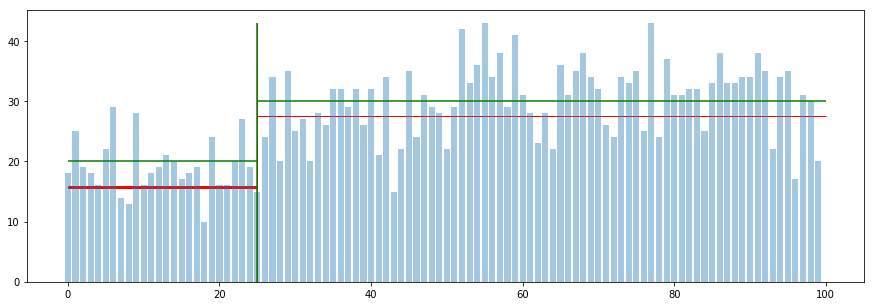

In [9]:
plt.figure(figsize=(15, 5))
plt.bar(t, y[0], alpha=.4)
plt.vlines(TSWITCH, ymin=0, ymax=max(y[0]), color='green')
plt.fill_between(x=[tswitch_inferred[0], tswitch_inferred[2]], y1=0, y2=max(y[0]), color='red')
plt.hlines(RATE1, xmin=TSTART, xmax=TSWITCH, color='green')
plt.fill_betweenx(y=[rate1_inferred[0], rate1_inferred[2]], x1=0, x2=TSWITCH, color='red')
plt.hlines(RATE2, xmin=TSWITCH, xmax=TEND, color='green')
plt.fill_betweenx(y=[rate2_inferred[0], rate2_inferred[2]], x1=TSWITCH, x2=TEND, color='red')
plt.show()